In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as color
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.metrics.pairwise import euclidean_distances
import os
import imageio
from IPython.display import Image
import time
import timeit


### Cсылка на github: 
github.com/DrEternity/IML_2021.git

# Моя реализация Kmeans

Спецификация:
1. #### Инициализация объекта класса:  

    **init** - стратегия начально инициализации: default: random; kmeans++; widely  
    **max_iterint** - макисмальное число итераций алгоритма  
    **eps** - норма Фробениуса от разницы центров кластеров двух последовательных итераций для завершения алгоритма
2. #### Методы:   

    **fit**(X, n_clusters, n_init)   **X** - множество точек,  **n_clusters** - требуемое число кластеров, **n_init** - число запусков алгоритма    
      
    **determining_number_clusters**(X, max_clusters, n_init) **X** - множество точек,  **max_clusters** - граница поиска кластеров, **n_init** - число запусков алгоритма
3. #### Атрибуты:  

    **min_loss_value**  - loss конечной кластеризации (**loss** - сумма расстояний от точкек до центроида соответсвующего кластера)  
    **centroids**  - центроиды итогового разбиения  
    **labels** - метки принадлежности кластерам (числа от **0** до **n_clusters - 1**)


In [224]:
class KMEANS_my:
    def __init__(self, init = 'random', max_iterint = 300, 
            eps = 1e-4):
        self.init = init
        self.max_iterint = max_iterint
        self.eps = eps
        self.min_loss_value = -1
        
    def _kmeans_plus_plus_init(self, X):
        centers = np.empty((self.n_clusters, X.shape[1]), dtype=X.dtype)
        n_local_trials = 2 + int(np.log(self.n_clusters))

        center_id = np.random.randint(X.shape[0])
        
        centers[0] = X[center_id]
        closest_dist_sq = euclidean_distances(centers[0, np.newaxis], X, squared = True)
        current_pot = closest_dist_sq.sum()
        for c in range(1, self.n_clusters):
            rand_vals = np.random.random_sample(n_local_trials) * current_pot
            candidate_ids = np.searchsorted(np.cumsum(closest_dist_sq), rand_vals)
            candidate_ids = np.clip(candidate_ids, None, closest_dist_sq.size - 1)

            distance_to_candidates = euclidean_distances(X[candidate_ids], X, squared=True)
            distance_to_candidates = np.minimum(closest_dist_sq, distance_to_candidates)
            candidates_pot = distance_to_candidates.sum(axis=1)

            best_candidate = np.argmin(candidates_pot)
            current_pot = candidates_pot[best_candidate]
            closest_dist_sq = distance_to_candidates[best_candidate]
            best_candidate = candidate_ids[best_candidate]
            centers[c] = X[best_candidate]
        return centers
    
    
    def _widely_init(self, X):
        centers = np.empty((self.n_clusters, X.shape[1]), dtype=X.dtype)
        center_id = np.random.randint(X.shape[0])
        centers[0] = X[center_id]

        closest_dist = np.log(euclidean_distances(centers[0, np.newaxis], X) + 1)
        for c in range(1, self.n_clusters):

            centers[c] = X[np.argmax(closest_dist)]
            closest_dist += np.log(euclidean_distances(centers[c, np.newaxis], X) + 1)
        return centers


    def _init_centroids(self, X):
        if self.init == 'random':
            seeds = np.random.choice(X.shape[0], size = self.n_clusters, replace=False)
            return X[seeds, :]
        if self.init == 'kmeans++':
            return self._kmeans_plus_plus_init(X)
        if self.init == 'widely':
            return self._widely_init(X)
            
    def determining_number_clusters(self, X, max_clusters, n_init, verbose = False):
        losses = np.array([self.fit(X, i, n_init).min_loss_value for i in range(1, min(X.shape[0], max_clusters))])
        if verbose:
            plt.plot(np.arange(1 , min(X.shape[0], max_clusters)) , losses)
            plt.grid()
        losses = losses[:-1] - losses[1:]
        losses = losses[:-1] / losses[1:]
        return np.argmax(losses[1:]) + 3
        
    
    def loss(self, X, curr_centroids):
        return euclidean_distances(curr_centroids, X).min(axis = 0).sum()


    def single_iter_kmeans(self, X, curr_centroids):
        current_labels = np.argmin(euclidean_distances(curr_centroids, X), axis = 0)
        last_centroids = curr_centroids
        curr_centroids = np.array([X[current_labels == j].mean(axis=0) for j in range(self.n_clusters)])
        return curr_centroids, last_centroids, current_labels
    

    def fit(self, X, n_clusters, n_init):
        self.min_loss_value = -1
        self.number_of_iter = []
        self.n_clusters = n_clusters
        self.loss_values = []
        
        EPS = self.eps * np.mean(np.var(X, axis = 0))

        
        for _ in range(n_init):

            curr_centroids = self._init_centroids(X)
            current_labels = None
                
            for i in range(self.max_iterint):
                curr_centroids, last_centroids, current_labels = self.single_iter_kmeans(X, curr_centroids)
                if (np.sum(((curr_centroids - last_centroids)) ** 2) <= EPS):
                    break
            self.number_of_iter.append(i)
            
            curr_loss_value = self.loss(X, curr_centroids)
            self.loss_values.append(curr_loss_value)
            if (self.min_loss_value == -1 or self.min_loss_value > curr_loss_value):
                self.min_loss_value = curr_loss_value
                self.centroids = curr_centroids
                self.labels = current_labels
        
        return self

# 1. Для каких данных подходит?

#### Ниже представлены результаты работы алгоритма Kmeans на разных типах данных:

In [226]:
class Test():
    def __init__(self, algo, random_state = 666):
        self.random_state = random_state
        self.algo = algo
    def testing(self):
        transformation = [[0.6, -0.6], [-0.4, 0.8]]
        time_now = round(time.perf_counter()) // self.random_state
        lib = {
                'blobs' : {'n_samples' : [2000, 1000, 500, 200, 700], 'centers' : [15, 10, 6, 5, 7], 'random' : [time_now, time_now ** 2, time_now * 2, time_now // 7, time_now * 13]},
                'circles' : {'n_samples' : [1000, 1000, 1000, 2000, 2000], 'factor' : [.8, .5, .4, .7, .6], 'noise' : [0.05, 0.07, 0.09, 0.02, 0.01]},
                'elongated' : {'n_samples' : [1500, 1550, 1350, 1600, 1900], 'centers' : [8, 6, 5, 7, 4], 'random' : [time_now, time_now ** 2, time_now * 2, time_now // 7, time_now * 13]},
                'moons' : {'n_samples' : [1000, 1000, 1000, 2000, 2000], 'noise' : [0.05, 0.07, 0.09, 0.02, 0.01]}
        }    
        fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize=(15,12)) 
        
        for i in range(len(lib['blobs']['n_samples'])):
            X, y = make_blobs(n_samples = lib['blobs']['n_samples'][i], centers = lib['blobs']['centers'][i], random_state = lib['blobs']['random'][i])
            axes[0, i].scatter(X[:, 0], X[:, 1], c = self.algo.fit(X, lib['blobs']['centers'][i], 1).labels, alpha= 0.7, edgecolor='k')
            axes[0, i].xaxis.set_visible(False)
            axes[0, i].yaxis.set_visible(False)

        for i in range(len(lib['circles']['n_samples'])):
            X, y = make_circles(n_samples = lib['circles']['n_samples'][i], factor = lib['circles']['factor'][i], noise = lib['circles']['noise'][i], random_state = datetime.now().second) 
            axes[1, i].scatter(X[:, 0], X[:, 1], c = self.algo.fit(X, 2, 1).labels, alpha= 0.7, edgecolor='k')
            axes[1, i].xaxis.set_visible(False)
            axes[1, i].yaxis.set_visible(False)
            
        for i in range(len(lib['blobs']['n_samples'])):
            X, y = make_blobs(n_samples = lib['elongated']['n_samples'][i], centers = lib['elongated']['centers'][i], random_state = lib['elongated']['random'][i])
            X_aniso = np.dot(X, transformation)
            axes[2, i].scatter(X_aniso[:, 0], X_aniso[:, 1], c = self.algo.fit(X_aniso, lib['elongated']['centers'][i], 1).labels, alpha= 0.7, edgecolor='k')
            axes[2, i].xaxis.set_visible(False)
            axes[2, i].yaxis.set_visible(False)
            
        for i in range(len(lib['moons']['n_samples'])):
            X, y = make_moons(n_samples = lib['moons']['n_samples'][i], noise = lib['moons']['noise'][i])
            axes[3, i].scatter(X[:, 0], X[:, 1], c = self.algo.fit(X, 2, 1).labels, alpha= 0.7, edgecolor='k')
            axes[3, i].xaxis.set_visible(False)
            axes[3, i].yaxis.set_visible(False)
        
        plt.show()

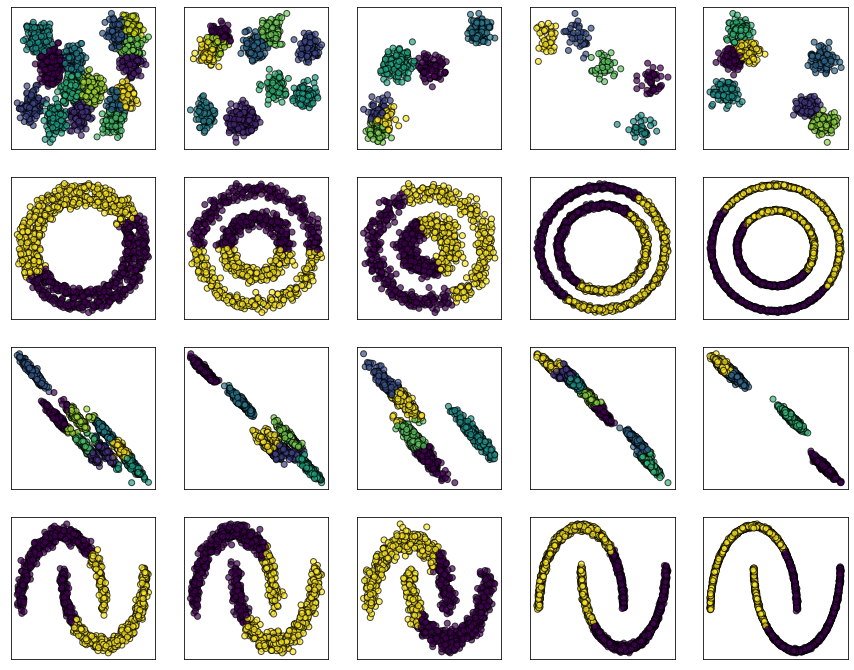

In [227]:
model_kmeans = KMEANS_my(init = "kmeans++")
Test(model_kmeans, 1002).testing()

## Вывод
Алгоритм Kmeans способен разделять данные, имеющие лишь
**"шарообразную форму"** без сильно выраженных растяжений.

# 2. Зависимость от стратегии начальной инициализации

Мной были проведены тесты для трёх типов начальной инициализации:
1.  **kmeans++**
2. **Эвристика (widely)**: 1й центр - случайный объект, 2й - максимально удалён от первого, 3й - максимально удалён от предыдущих центров и т.д.
3.  **random**


#### Подробное описание испытаний смотрите ниже

In [228]:
class Test2():
    def __init__(self, random_state = 400, num = 25, a = 10000, b = 500000):
        self.random_state = random_state
        self.num = num
        self.a = a
        self.b = b
        self.sizes_of_data = np.linspace(a, b, num).astype(np.int64)
        self.clusters = np.round_(np.log(self.sizes_of_data)).astype(np.int64)
        self.random_array = np.random.randint(random_state, random_state ** 2, size = num)
    
    def testing(self, algo):
        num_iter, std_loss, max_loss, min_loss, mean_loss = [], [], [], [], []
        for j in range(self.sizes_of_data.size):
            
            X, y = make_blobs(n_samples = self.sizes_of_data[j], centers = self.clusters[j], random_state = self.random_array[j])
            algo.fit(X, self.clusters[j], 10)
            
            loss_values_np = np.array(algo.loss_values)
            mean_loss.append(loss_values_np.mean())
            min_loss.append(algo.min_loss_value)
            max_loss.append(loss_values_np.max())
            std_loss.append(loss_values_np.std())
            num_iter.append(algo.number_of_iter)
        return num_iter, std_loss, max_loss, min_loss, mean_loss

In [229]:
v = Test2(random_state = 400, a = 10000, b = 500000, num = 25)
num_iter_1, std_loss_1, max_loss_1, min_loss_1, mean_loss_1 = v.testing(KMEANS_my(init = 'kmeans++'))
num_iter_2, std_loss_2, max_loss_2, min_loss_2, mean_loss_2 = v.testing(KMEANS_my(init = 'random'))
num_iter_3, std_loss_3, max_loss_3, min_loss_3, mean_loss_3 = v.testing(KMEANS_my(init = 'widely'))

### Описание тестов

1. Количество точек: 25 различных чисел равномерно расположенных на отрезке [10000, 500000]
2. Количество кластеров: натуральный логарифм от числа точек в тесте
3. Каждая из выборок запускается 10 раз
4. loss - сумма расстояний от точкек до центроида соответсвующего кластера
5. mean_loss - средний loss при 10 запусках на одном тесте
6. std_loss - стандартное отклонение loss при 10 запусках на одном тесте
7. count_iterations - количество проделанных итераций до сходимости с точность eps = 1e-4
8. widely - моё название второго способа инициализации

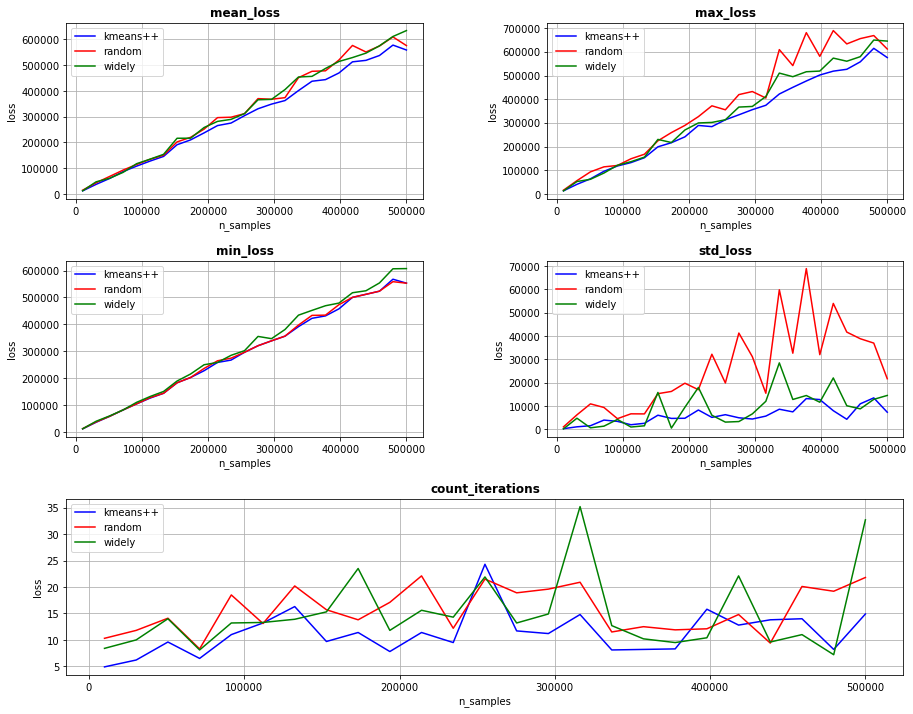

In [230]:
fig = plt.figure(figsize=(15,12)) 

ax_1 = fig.add_subplot(3, 2, 1)
ax_1.set_title("mean_loss", fontweight='bold')
ax_1.grid()
ax_1.set_xlabel("n_samples")
ax_1.set_ylabel("loss")
ax_1.plot(v.sizes_of_data, mean_loss_1, c = 'b', label = "kmeans++")
ax_1.plot(v.sizes_of_data, mean_loss_2, c = 'r', label = "random")
ax_1.plot(v.sizes_of_data, mean_loss_3, c = 'g', label = "widely")
ax_1.legend()

ax_2 = fig.add_subplot(3, 2, 2)
ax_2.set_title("max_loss", fontweight='bold')
ax_2.grid()
ax_2.set_xlabel("n_samples")
ax_2.set_ylabel("loss")
ax_2.plot(v.sizes_of_data, max_loss_1, c = 'b', label = "kmeans++")
ax_2.plot(v.sizes_of_data, max_loss_2, c = 'r', label = "random")
ax_2.plot(v.sizes_of_data, max_loss_3, c = 'g', label = "widely")
ax_2.legend()

ax_3 = fig.add_subplot(3, 2, 3)
ax_3.set_title("min_loss", fontweight='bold')
ax_3.grid()
ax_3.set_xlabel("n_samples")
ax_3.set_ylabel("loss")
ax_3.plot(v.sizes_of_data, min_loss_1, c = 'b', label = "kmeans++")
ax_3.plot(v.sizes_of_data, min_loss_2, c = 'r', label = "random")
ax_3.plot(v.sizes_of_data, min_loss_3, c = 'g', label = "widely")
ax_3.legend()


ax_4 = fig.add_subplot(3, 2, 4)
ax_4.set_title("std_loss", fontweight='bold')
ax_4.grid()
ax_4.set_xlabel("n_samples")
ax_4.set_ylabel("loss")
ax_4.plot(v.sizes_of_data, std_loss_1, c = 'b', label = "kmeans++")
ax_4.plot(v.sizes_of_data, std_loss_2, c = 'r', label = "random")
ax_4.plot(v.sizes_of_data, std_loss_3, c = 'g', label = "widely")
ax_4.legend()

ax_5 = fig.add_subplot(3, 1, 3)
ax_5.set_title("count_iterations", fontweight='bold')
ax_5.grid()
ax_5.set_xlabel("n_samples")
ax_5.set_ylabel("loss")
ax_5.plot(v.sizes_of_data, np.array(num_iter_1).mean(axis=1), c = 'b', label = "kmeans++")
ax_5.plot(v.sizes_of_data, np.array(num_iter_2).mean(axis=1), c = 'r', label = "random")
ax_5.plot(v.sizes_of_data, np.array(num_iter_3).mean(axis=1), c = 'g', label = "widely")
ax_5.legend()

plt.subplots_adjust(wspace = 0.35, hspace = 0.35)



# Вывод

Как видно из графиков **kmeans++** демонстрирует лучший результат во всех показателях. С ростом выборки его превосходство становится заметнее. **Widely** показывает хорошие показатели **loss**, но имеет большее число итераций для сходимости. Для успешного использования **random** придётся обязательно прибегать к нескольким запускам для поиска наименьшего **loss**

# 3. Стратегия выбора числа кластеров

Я использую метод **"локтя"** для определения числа кластеров

10

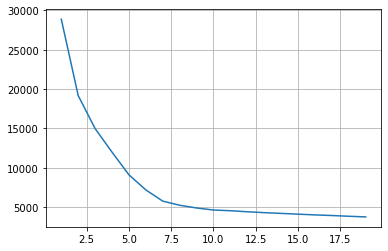

In [221]:
X, y = make_blobs(n_samples = 4000, centers = 10, random_state = 11345)
KMEANS_my(init = 'kmeans++').determining_number_clusters(X, 20, 5, verbose = True)

In [222]:
random_states = np.random.randint(7289, size = 5)
random_clusters = np.random.randint(20, size = 5)
results = []
for i in [1000, 2000, 3000]:
    for j in random_states:
        for t in random_clusters:
            X, y = make_blobs(n_samples = i, centers = t, random_state = j)
            num_clusters = KMEANS_my(init = 'kmeans++').determining_number_clusters(X, 25, 5)
            results.append(t - num_clusters)
np.sum(np.absolute(np.array(results))) / 75

2.96


Тесты показали, что на выборках с **[1000, 2000, 3000]** точками и  **[1, 20]** кластерами среднее абсолютное отклонение составило **2.96**. Проведено **75** тестов.

# Вывод

Метод **"локтя"** показал высокую точность на выборках с тысячами точек и десятками кластеров

   # 4. Зависимость скорости настройки алгоритма от объёма данных и сложности задачи

In [231]:
class Test3():
    def __init__(self, algo, random_state = 111):
        self.algo = algo
        self.random_state = random_state
        self.n_samples = np.array([1000, 2000, 2500, 3000])    
        self.clusters = np.arange(5, 200, 10)
        self.random_state = random_state
    def testing(self):
        fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20,20)) 
        for i in range(self.n_samples.size):
            current_times = []
            
            x_place = i // 2
            y_place = i % 2
            for j in range(self.clusters.size):
                sum_time = 0
                for k in range(5):
                    X, y = make_blobs(n_samples = self.n_samples[i], centers = self.clusters[j], random_state = np.random.randint(self.random_state, size = 1)[0])
                    def tmp():
                        self.algo.fit(X, self.clusters[j], 1)
                    elapsed_time = timeit.timeit(tmp, number = 1)
                    sum_time += elapsed_time
                current_times.append(sum_time / 5)
            axes[x_place, y_place].set_title(f'samples = {self.n_samples[i]}', fontweight='bold')
            axes[x_place, y_place].plot(self.clusters , current_times, c = 'r')
            axes[x_place, y_place].grid()
            axes[x_place, y_place].set_ylabel("time")
            axes[x_place, y_place].set_xlabel("clusters")

            

In [232]:
t = Test3(KMEANS_my(init = 'kmeans++'), 9091)

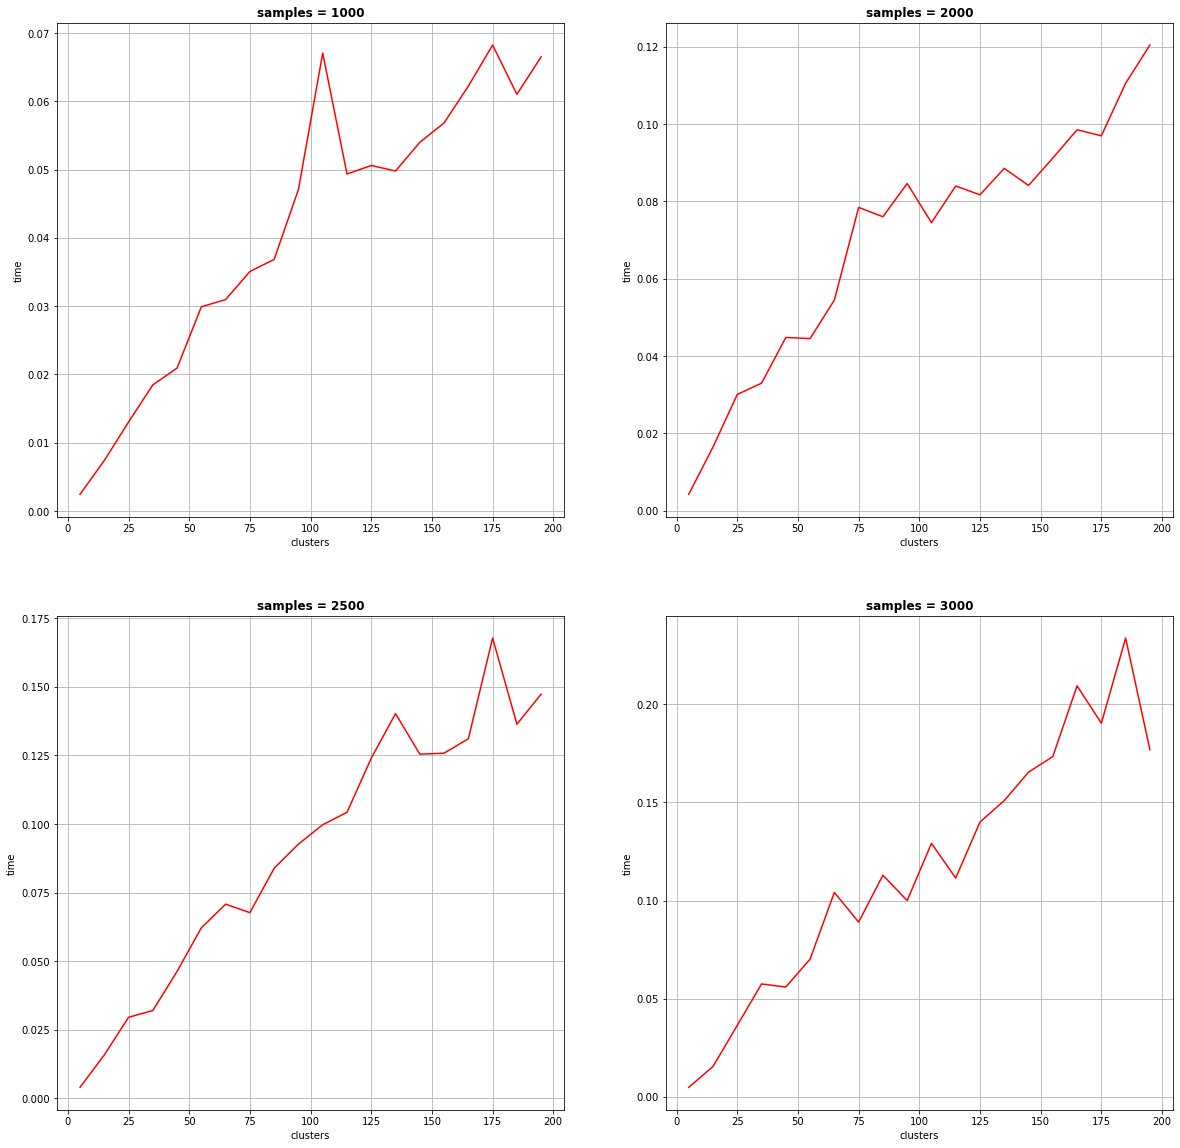

In [233]:
t.testing()

In [259]:
class Test4():
    def __init__(self, algo, random_state = 111):
        self.algo = algo
        self.random_state = random_state
        self.sizes_of_data = np.linspace(10000, 500000, 40).astype(np.int64)     
        self.clusters = np.round_(np.log(self.sizes_of_data)).astype(np.int64)
        self.random_state = random_state
    def testing(self):
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(111) 
        current_times = []
        for i in range(self.sizes_of_data.size):
            sum_time = 0
            for k in range(5):
                X, y = make_blobs(n_samples = self.sizes_of_data[i], centers = self.clusters[i], random_state = np.random.randint(self.random_state, size = 1)[0])
                def tmp():
                    self.algo.fit(X, self.clusters[i], 1)
                elapsed_time = timeit.timeit(tmp, number = 3)
                sum_time += elapsed_time
            current_times.append(sum_time / 5)
        ax.set_title('Dependence for cluster =  ln(samples)', fontweight='bold')
        ax.plot(self.sizes_of_data , current_times, c = 'r')
        ax.grid()
        ax.set_ylabel("time")
        ax.set_xlabel("samples")

            

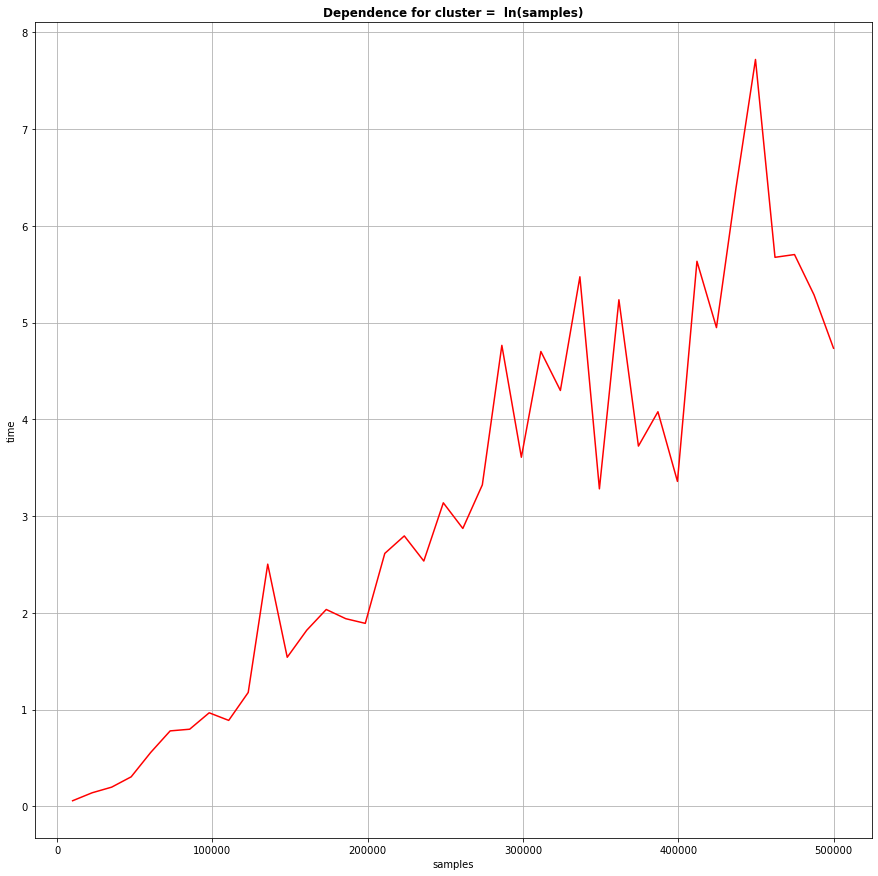

In [260]:
t = Test4(KMEANS_my(init = 'kmeans++'), 9144)
t.testing()

# 5. Эвристика для визулизации матрицы попарных расстояний

**Моё упорядочивание:**  
1.    Найти самый отдалённый кластер относительно других
2.    Последовательно искать ближайший не посещённый кластер к текущему

In [266]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

In [267]:
def comfort_X(X, clusters):
    v = KMEANS_my(init = "kmeans++").fit(X, clusters, n_init = 1)
    
    sum_centroids_dist = np.zeros(v.centroids.shape[0]).reshape(1, clusters)
    for i in v.centroids:
        t = np.log(euclidean_distances(i.reshape(1, 2), v.centroids) + 1)
        sum_centroids_dist += t


    color_seq = []
    place = sum_centroids_dist.argmin()
    last_center = v.centroids[place]
    used = np.zeros(clusters)

    for i in range(0, clusters):
        t = euclidean_distances(last_center.reshape(1, 2), 
                                v.centroids)
        indexes = np.argsort(t).squeeze()
        for i in range(indexes.size):
            if used[indexes[i]] == 0:
                color_seq.append(indexes[i]) 
                used[indexes[i]] = 1
                last_center = v.centroids[indexes[i]]
                break


    new = np.hstack((X, v.labels.reshape(v.labels.size, 1)))
    X_new = new[new[:, 2] == color_seq[0]][:,0:2]
    for j in range(1, len(color_seq)):
        X_new = np.vstack((X_new, new[new[:, 2] == color_seq[j]][:,0:2]))
    return X_new

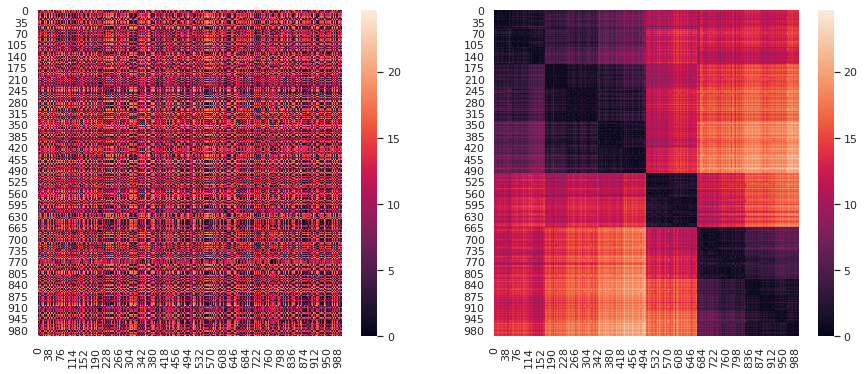

In [289]:
X, y = make_blobs(n_samples = 1000, centers = 6, random_state = 158)
X_new = comfort_X(X, 15)
fig, (ax_1, ax_2) = plt.subplots(ncols = 2, figsize=(15,6))

uniform_data_1 = euclidean_distances(X, X)
sns.heatmap(uniform_data_1, ax = ax_1)
uniform_data_2 = euclidean_distances(X_new, X_new)
sns.heatmap(uniform_data_2, ax = ax_2)
plt.show()